In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gymnasium[classic-control] torch numpy matplotlib
!apt-get install -y xvfb
!pip install pyvirtualdisplay imageio[ffmpeg] moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [18]:
!apt-get install -y xvfb
!pip install pyvirtualdisplay
!pip install imageio imageio-ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [36]:
!mkdir -p /usr/local/lib/python3.11/dist-packages/gym/envs/classic_control/assets


In [37]:
!wget https://github.com/openai/gym/blob/master/gym/envs/classic_control/assets/clockwise.png?raw=true -O /usr/local/lib/python3.11/dist-packages/gym/envs/classic_control/assets/clockwise.png


--2025-04-15 18:06:10--  https://github.com/openai/gym/blob/master/gym/envs/classic_control/assets/clockwise.png?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/openai/gym/raw/refs/heads/master/gym/envs/classic_control/assets/clockwise.png [following]
--2025-04-15 18:06:10--  https://github.com/openai/gym/raw/refs/heads/master/gym/envs/classic_control/assets/clockwise.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/openai/gym/refs/heads/master/gym/envs/classic_control/assets/clockwise.png [following]
--2025-04-15 18:06:10--  https://raw.githubusercontent.com/openai/gym/refs/heads/master/gym/envs/classic_control/assets/clockwise.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 18

In [24]:
!pip uninstall -y gym
!pip install gymnasium imageio imageio-ffmpeg


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2


In [39]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

In [40]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []

        for state, action, reward, next_state, done in batch:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.float32),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.float32))

    def __len__(self):
        return len(self.buffer)

In [41]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_scale=2.0):
        super(Actor, self).__init__()
        self.action_scale = action_scale
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * self.action_scale
        return x

In [42]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [51]:
def train_qprop(render=False, verbose=True):
    # Environment setup
    env = gym.make("Pendulum-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_low = float(env.action_space.low[0])
    action_high = float(env.action_space.high[0])
    action_scale = (action_high - action_low) / 2

    # Hyperparameters
    gamma = 0.99
    tau = 0.005
    batch_size = 256
    kl_constraint = 0.01
    noise_std_init = 0.3
    noise_std_min = 0.05
    noise_decay = 0.99
    num_episodes = 1000
    max_steps = 200
    updates_per_step = 1

    # Initialize models
    actor = Actor(state_dim, action_dim, action_scale=action_scale)
    critic = Critic(state_dim, action_dim)
    target_actor = Actor(state_dim, action_dim, action_scale=action_scale)
    target_critic = Critic(state_dim, action_dim)

    # Copy weights to target networks
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

    # Initialize optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
    critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)

    # Initialize replay buffer
    buffer = ReplayBuffer(int(1e6))

    # Tracking variables
    returns_log = []
    q_values_log = []
    actor_losses = []
    critic_losses = []

    # Function to select action with exploration noise
    def select_action(state, noise_std):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            mean = actor(state)
            action = mean + noise_std * torch.randn_like(mean)
            return action.clamp(action_low, action_high).flatten().numpy(), mean.flatten().numpy()

    # Function to soft update target networks
    def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    # Function to update critic
    def update_critic(batch_size):
        if len(buffer) < batch_size:
            return 0

        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = buffer.sample(batch_size)

        # Convert to torch tensors
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Compute target Q-value
        with torch.no_grad():
            next_actions = target_actor(next_states)
            target_q = rewards + gamma * target_critic(next_states, next_actions) * (1 - dones)

        # Compute current Q-value
        current_q = critic(states, actions)

        # Compute critic loss
        critic_loss = nn.MSELoss()(current_q, target_q)

        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        return critic_loss.item()

    # Function to update actor using QProp
    def update_actor(batch_size):
        if len(buffer) < batch_size:
            return 0, 0

        # Sample batch from replay buffer
        states, _, _, _, _ = buffer.sample(batch_size)
        states = torch.FloatTensor(states)

        # Compute QProp policy gradient
        # First, get deterministic actions from current policy
        with torch.no_grad():
            baseline_actions = actor(states)
            baseline_q = critic(states, baseline_actions)

        # Get policy actions with gradient enabled
        actions = actor(states)
        q_values = critic(states, actions)

        # Compute advantage
        advantage = q_values - baseline_q

        # Compute KL divergence between current policy and previous policy
        kl_div = ((actions - baseline_actions) ** 2).mean()

        # QProp policy loss with KL constraint
        actor_loss = -(advantage.mean() - kl_constraint * kl_div)

        # Update actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        return actor_loss.item(), q_values.mean().item()

    # Collect initial data for replay buffer
    print("Collecting initial data...")
    try:
        state, _ = env.reset()
    except:
        state = env.reset()

    for _ in range(10000):
        action = env.action_space.sample()
        try:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        except:
            next_state, reward, done, _ = env.step(action)

        buffer.push(state, action, reward, next_state, float(done))
        state = next_state
        if done:
            try:
                state, _ = env.reset()
            except:
                state = env.reset()

    # Training loop
    print("Training QProp agent...")
    noise_std = noise_std_init
    total_steps = 0

    for episode in range(num_episodes):
        try:
            state, _ = env.reset()
        except:
            state = env.reset()

        episode_reward = 0
        episode_steps = 0
        episode_actor_loss = 0
        episode_critic_loss = 0
        episode_q_values = 0

        for step in range(max_steps):
            # Select action with exploration noise
            action, _ = select_action(state, noise_std)

            # Execute action in environment
            try:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            except:
                next_state, reward, done, _ = env.step(action)

            # Store transition in replay buffer
            buffer.push(state, action, reward, next_state, float(done))

            # Update state and counters
            state = next_state
            episode_reward += reward
            episode_steps += 1
            total_steps += 1

            # Update networks
            for _ in range(updates_per_step):
                critic_loss = update_critic(batch_size)
                actor_loss, q_value = update_actor(batch_size)

                episode_critic_loss += critic_loss
                episode_actor_loss += actor_loss
                episode_q_values += q_value

                # Soft update target networks
                soft_update(target_actor, actor, tau)
                soft_update(target_critic, critic, tau)

            if done:
                break

        # Decay exploration noise
        noise_std = max(noise_std_min, noise_std * noise_decay)

        # Log episode statistics
        if episode_steps > 0:
            episode_actor_loss /= episode_steps * updates_per_step
            episode_critic_loss /= episode_steps * updates_per_step
            episode_q_values /= episode_steps * updates_per_step

        returns_log.append(episode_reward)
        actor_losses.append(episode_actor_loss)
        critic_losses.append(episode_critic_loss)
        q_values_log.append(episode_q_values)

        # Print episode statistics
        if verbose and (episode % 10 == 0 or episode == num_episodes - 1):
            avg_return = np.mean(returns_log[-10:])
            print(f"Episode {episode}, Steps: {episode_steps}, Return: {episode_reward:.2f}, Avg Return (last 10): {avg_return:.2f}")

    # Plot training curves
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(returns_log)
    plt.title('Episode Returns')
    plt.xlabel('Episode')
    plt.ylabel('Return')

    plt.subplot(2, 2, 2)
    plt.plot(q_values_log)
    plt.title('Q-Values')
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')

    plt.subplot(2, 2, 3)
    plt.plot(actor_losses)
    plt.title('Actor Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 3)
    plt.plot(critic_losses)
    plt.title('Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.savefig('qprop_training_curves.png')
    plt.show()

    print("\nTesting trained policy...")
    try:
        state, _ = env.reset()
    except:
        state = env.reset()

    done = False
    total_reward = 0
    steps = 0

    while not done and steps < max_steps:
        action, _ = select_action(state, 0)
        try:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        except:
            next_state, reward, done, _ = env.step(action)

        state = next_state
        total_reward += reward
        steps += 1

    print(f"Test episode completed with total reward: {total_reward:.2f}")

    env.close()

    return actor, critic, returns_log



In [52]:
from IPython.display import HTML
from base64 import b64encode
import imageio

def save_and_play_policy_video(actor, filename="/content/drive/MyDrive/qprop_pendulum2.mp4", num_frames=200):
    render_env = gym.make("Pendulum-v1", render_mode="rgb_array")

    # Reset environment
    try:
        state, _ = render_env.reset()
    except:
        state = render_env.reset()

    frames = []
    total_reward = 0

    # Collect frames
    for _ in range(num_frames):
        # Render frame
        frame = render_env.render()
        if frame is not None:
            frames.append(frame)

        # Get action from policy network
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor(state_tensor).numpy()[0]

        # Take step in environment
        try:
            next_state, reward, terminated, truncated, _ = render_env.step(action)
            done = terminated or truncated
        except:
            next_state, reward, done, _ = render_env.step(action)

        state = next_state
        total_reward += reward

        if done:
            break

    # Save video
    if frames:
        imageio.mimsave(filename, frames, fps=30)
        print(f"Video saved to {filename}")
        print(f"Total reward: {total_reward:.2f}")

        # Display video in Colab
        mp4 = open(filename, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)
    else:
        print("No frames were captured")
        return None

Training QProp agent...
Episode 0, Steps: 200, Return: -1693.10, Avg Return (last 10): -1693.10
Episode 10, Steps: 200, Return: -1146.19, Avg Return (last 10): -1501.72
Episode 20, Steps: 200, Return: -1202.16, Avg Return (last 10): -640.01
Episode 30, Steps: 200, Return: -127.67, Avg Return (last 10): -147.00
Episode 40, Steps: 200, Return: -120.47, Avg Return (last 10): -141.17
Episode 50, Steps: 200, Return: -116.05, Avg Return (last 10): -138.02
Episode 60, Steps: 200, Return: -3.34, Avg Return (last 10): -108.81
Episode 70, Steps: 200, Return: -226.88, Avg Return (last 10): -142.21
Episode 80, Steps: 200, Return: -232.25, Avg Return (last 10): -163.64
Episode 90, Steps: 200, Return: -114.87, Avg Return (last 10): -109.35
Episode 100, Steps: 200, Return: -243.19, Avg Return (last 10): -161.27
Episode 110, Steps: 200, Return: -245.59, Avg Return (last 10): -146.39
Episode 120, Steps: 200, Return: -130.01, Avg Return (last 10): -156.33
Episode 130, Steps: 200, Return: -120.62, Avg Re

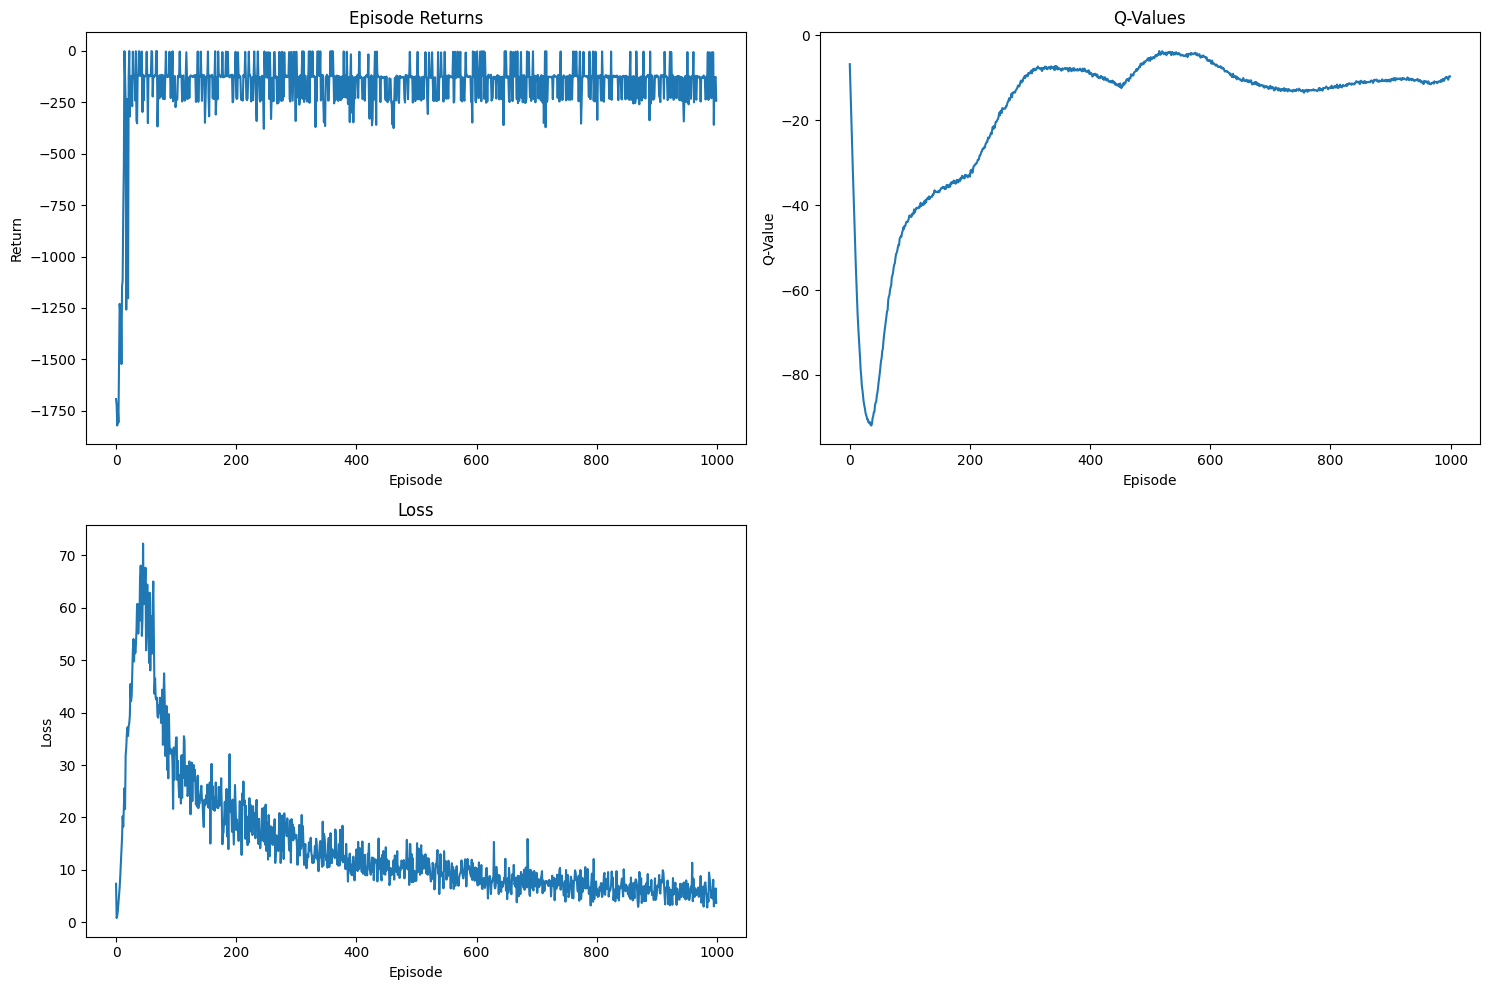


Testing trained policy...
Test episode completed with total reward: -121.53


In [53]:
if __name__ == "__main__":
    actor, critic, returns = train_qprop(render=False)

    torch.save(actor.state_dict(), 'qprop_actor.pth')
    torch.save(critic.state_dict(), 'qprop_critic.pth')


In [56]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [61]:
def load_and_play_model():
    state_dim = 3
    action_dim = 1
    action_scale = 2.0

    loaded_actor = Actor(state_dim, action_dim, action_scale=action_scale)

    loaded_actor.load_state_dict(torch.load('qprop_actor.pth'))

    video_display = save_and_play_policy_video(loaded_actor)
    display(video_display)



In [48]:
load_and_play_model()


Video saved to /content/qprop_pendulum.mp4
Total reward: -1283.89


In [58]:
import torch
import numpy as np
import imageio
from IPython.display import HTML
from base64 import b64encode

def save_and_play_policy_video(actor, filename="/content/qprop_pendulum.mp4", num_frames=200):
    render_env = gym.make("Pendulum-v1", render_mode="rgb_array")
    try:
        state, _ = render_env.reset()
    except:
        state = render_env.reset()

    frames = []
    total_reward = 0

    for _ in range(num_frames):
        # Action selection
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor(state_tensor).numpy()[0]

        # Clip for safety
        action = np.clip(action, render_env.action_space.low, render_env.action_space.high)

        # Step
        try:
            next_state, reward, terminated, truncated, _ = render_env.step(action)
            done = terminated or truncated
        except:
            next_state, reward, done, _ = render_env.step(action)

        state = next_state
        total_reward += reward

        # Capture frame
        frame = render_env.render()
        if frame is not None:
            frames.append(frame)

        if done:
            break

    # Save video
    if frames:
        imageio.mimsave(filename, frames, fps=30)
        print(f"Video saved to {filename}")
        print(f"Total reward: {total_reward:.2f}")

        mp4 = open(filename, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)
    else:
        print("No frames were captured")
        return None


In [63]:
state_dim = 3
action_dim = 1
action_scale = 2.0

loaded_actor = Actor(state_dim, action_dim, action_scale=action_scale)

loaded_actor.load_state_dict(torch.load('qprop_actor.pth'))
save_and_play_policy_video(loaded_actor)

Video saved to /content/qprop_pendulum.mp4
Total reward: -230.92
